## DataLoader

In [1]:
import numpy as np
import pandas as pd
import os
import keras
from math import ceil
from preprocess import DictPrepross, Zero_One, Normalizer
from netCDF4 import Dataset

data_folder="Data"
class Basic_Generator(keras.utils.Sequence):
    """
    Use hdf5 datasets and simply return the desire variables
    To create a new Generator simply inherit this one and change '__init__' and __'data_generation
    """
    def __init__(self, folder=data_folder, train=True, batch_size=64, shuffle=True, custom_b_p_e = 0):
        # global parameters
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_b = custom_b_p_e
        # initialisation
        self._set_dirs(folder)
        self._initialise_parameters()
        # idx
        self.idx_folder = np.arange(self._nb_dir)
        self.idx_file = np.arange(self._div)
        self.idx_el = np.arange(self.Xdim*self.Ydim)
        self.current_b = 0

        self.current_folder = 0
        self.current_file = 0
        # randomize
        self.on_epoch_end()
                
    def _set_dirs(self, datafolder):
        self.List_of_dir = []
        folders = os.listdir(datafolder)
        folders.sort()
        for i in folders:
            if os.path.isdir(os.path.join(datafolder,i)):
                self.List_of_dir.append(os.path.join(datafolder,i))
        if(self.train):  # last folder is used as test
            self.List_of_dir = self.List_of_dir[:-1]
        else:
            self.List_of_dir = self.List_of_dir[:-1]
        self._nb_dir = len(self.List_of_dir)
        
    def _initialise_parameters(self):
        """ load one file to compute variables such as the dimensions, the name of var etc """
        x, y = self.load_a_couple(self.load_a_path(0,0))
        self._div = int(len(os.listdir(self.List_of_dir[0]))/2)
        self.variables = x.columns.levels[0]
        self.variables_pred = y.columns.levels[0]
        self.Xdim = len(x.index.levels[0])
        self.Ydim = len(x.index.levels[1])
        self.lev = len(x.columns.levels[1])
    
    def load_a_path(self, id_fold, id_file):
        for f in os.listdir(self.List_of_dir[id_fold]):
            if '_in' in f and '_'+str(id_file)+'.' in f:
                input_path = os.path.join(self.List_of_dir[id_fold], f)
            if '_out' in f and '_'+str(id_file)+'.' in f:
                output_path = os.path.join(self.List_of_dir[id_fold], f)        
        return (input_path, output_path)
        
    def load_a_couple(self, path):
        """Load x and y files given by the two values of path"""
        return  pd.read_hdf(path[0], key='s'), pd.read_hdf(path[1], key='s')

    @property
    def dimensions(self):
        d=dict()
        d['div'] = (self._div)
        d['var'] = len(self.variables)
        d['x'] = self.Xdim
        d['y'] = self.Ydim
        d['lev'] = self.lev
        d['dir'] = self._nb_dir
        return(d)
        
    def __len__(self):
        'batch per size'
        l = int( (self.Xdim * self.Ydim // self.batch_size) * self._div * self._nb_dir)
        if (self.max_b > 0):
            return(min(self.max_b, l))            
        return(l)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.current_b = 0
        if self.shuffle == True:
            np.random.shuffle(self.idx_folder)
            np.random.shuffle(self.idx_file)
            np.random.shuffle(self.idx_el)
        self.reload(self.idx_folder[0], self.idx_file[0])
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        folder_id, file_id, el_id  = self.index_to_ids(index)
        # use the shuffled indices
        folder_id = self.idx_folder[folder_id]
        file_id = self.idx_file[file_id]
        el_ids = self.idx_el[el_id*self.batch_size + np.arange(self.batch_size)]
        return( self.__data_generation(folder_id, file_id, el_ids))
                
    def index_to_ids(self,index):
        index0 = index
        batch_per_file = (self.Xdim*self.Ydim // self.batch_size) 
        el_id = index0 % batch_per_file 
        index0 = index0 // batch_per_file
        file_id = index0 % self._div
        folder_id   = index0 // self._div
        return folder_id, file_id, el_id

    def reload(self,folder_id, file_id):
        """ Files are only loaded when the id of the file or folder is changed, this mutiply the speed by about 400"""
        if folder_id != self.current_folder or file_id != self.current_file:
            self.current_folder = folder_id
            self.current_file = file_id      
            self.X, self.Y = self.load_a_couple(self.load_a_path(self.current_folder, self.current_file))
    
    def __data_generation(self, folder_id, file_id, el_ids):
        'Generates data containing batch_size samples'
        self.reload(folder_id, file_id)
        X = np.array(self.X.iloc[el_ids]).reshape(self.batch_size, len(self.variables), self.lev)
        Y = np.array(self.Y.iloc[el_ids]).reshape(self.batch_size, len(self.variables_pred), self.lev+1)
        return X,Y

B = Basic_Generator(data_folder)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
class Generator(Basic_Generator):
    

In [3]:
from tqdm import tqdm
import time

beg = time.time()
for x,y in tqdm(B):
    pass
print(time.time()-beg)

100%|██████████| 19440/19440 [00:12<00:00, 1519.67it/s]

12.794521570205688


In [44]:
select_folder = np.random.randint(len(List_of_dir))
select_element = np.random.randint(div)

print(select_folder, select_element)
files = os.listdir(List_of_dir[select_folder])
for f in files:
    if '_in' in f and str(select_element)+'.' in f:
        input_path = os.path.join(List_of_dir[select_folder], f)
    if '_out' in f and str(select_element)+'.' in f:
        output_path = os.path.join(List_of_dir[select_folder], f)

0 1


In [45]:
x = pd.read_hdf(input_path, key='s')
y = pd.read_hdf(output_path, key='s')

In [3]:
import numpy as np

class Preprocess(object):
    """
    Parent class of Preprocessing class
    """
    def __init__(self):
        self.fitted=False
        pass

    def apply(self,x):
        return x

    def fit(self,x):
        self.fitted=True
        return x

    def __str__(self):
        return 'type : {} \nfitted : {} \nvalues : {} \n  '

class Normalizer(Preprocess):
    """
    Transform the input into a variable of mean 0 and norm 1
    """
    def __init__(self):
        super().__init__()
        self.m = 0
        self.std = 1

    def apply(self,x):
        x-=self.m
        x/=self.std
        return x

    def fit(self,x):
        self.fitted=True
        self.m = np.mean(x)
        self.std = np.std(x)

    def __str__(self):
        return super().__str__().format("Normalizer", self.fitted, (self.m, self.std))

class Zero_One(Preprocess):
    """
    Match the input to a variable in [0,1]
    """
    def __init__(self):
        super().__init__()
        self.max=1
        self.min=1

    def apply(self,x):
        x-=self.min
        x/=(self.max-self.min)
        return x

    def fit(self,x):
        self.fitted=True
        self.min = np.min(x)
        self.max = np.max(x)

    def __str__(self):
        return super().__str__().format("Zero_One", self.fitted, (self.max, self.min))

###################################### Dict preprocess class

class DictPrepross(object):
    """
    Dictionnary of Preprocess
    """
    def __init__(self, header, functions):
        self.dict=dict()
        for i,h in enumerate(header):
            self.dict[h]=functions[i]

    def fitonNetCDF(self, data_in):
        for k in self.dict.keys():
            self[k].fit(data_in[k][:])

    def apply(self,x,h):
        if h in self.dict.keys():
            return self[h].apply(x)
        else:
            return x

    def __getitem__(self,k):
        return self.dict[k]

    def __str__(self):
        out =''
        for h in self.dict.keys():
            out = out + '{} : {}'.format(h, str(self[h]))+'\n'
        return out

################################### KERNEL class

class Kernel(object):
    def __init__(self, ids):
        self.ids = ids

    def apply(self, x, header):
        return x

class ProdKernel(Kernel):
    def __init__(self, ids=[]):
        Kernel.__init__(self, ids)
        self.ids = ids
        self.header = []

    def apply(self, x, header):
        for ids in self.ids:
            id1 = np.where(ids[0] == header)[0]
            id2 = np.where(ids[1] == header)[0]
            k = x[:, :, id1]*x[:, :, id2]
            header.append(ids[0]+'*'+ids[1])
            x = np.concatenate((k, x), axis=-1)
        return x
    
class FKernel(Kernel):
    def __init__(self, func, gamma=1, ids=[]):
        Kernel.__init__(self, ids)
        self.func = func
        self.gamma = gamma
        self.fname = str(func).split(' ')[1]
        self.ids = ids

    def apply(self, x, xheader):
        xheader0 = xheader.copy()
        self.header = []
        for ids in self.ids:
            id1 = np.where(ids[0] == xheader)[0]
            k = self.func(x[:, :, id1])
            xheader0.append(fname+ids[0])
            x = np.concatenate((k, x), axis=-1)
        self.xheader = xheader
        return x

[30, 1]
[5]


In [2]:
batch_size = 64
HNn = [128,64,16,4] # hidden layer size
header = list(x.keys())[6:] # variables are relevant after "time"
kernels = []
testprop = 0.9
seed = 0
n,p = x['Xdim'].shape[0],x['Ydim'].shape[0]

np.random.seed(seed)
d = len(header) + np.sum(np.array( [len(k.header) for k in kernels]  ))
batch_per_epoch = int(n*p / batch_size)

header_dict = ["ql","qi","q","rl","ri","ts","t", "pl","emis","o3"]  # variable we preprocess
fct = [] # how to preprocess them
for i in range(5):
    fct.append(Zero_One())
for j in range(5):
    fct.append(Normalizer())
    
D = DictPrepross(header_dict, fct)
del(fct)
D.fitonNetCDF(x)

In [3]:
def generate_rnn(x, y, kernels, train_prop=0.9, header=['ql'], batch_size=16, preprocess=DictPrepross([], []),
                  maxbatch=-1, loading_prop=0.1, test_data=False):
    """"
    Generate a batch, randomly for a convolution NN, using only variable in header

    x : input data in NetCDF format
    y : output data in NetCDF format
    kernels : list of kernsl
    train_prop : proportion of the training set
    header : variable used
    lodaing_prop : loaded percentage of the whole data (equilibra between good batches and memory usage)
    batch_size : size of the generated batch
    preprocess : DictPrepross object to apply to the data
    maxbatch : number of batch produced, maxbacth<0 means an infinite number of batch
    """

    maxbatch = int(maxbatch)
    n = x['Xdim'].shape[0]
    nt = int(n * train_prop)  # id up to training
    p = x['Ydim'].shape[0]
    lev = x['lev'].shape[0]

    x_header = header
    x_header.sort()

    nbatch = 0
    while nbatch != maxbatch:
        y_shuffled = np.arange(p)  # Ydim id to be shuffled
        # Xdim id but to be shuffled
        if test_data:
            x_shuffled =  np.arange(n - nt)  # test
            x_max = n  # Xdim not to outgrow
        else:
            x_shuffled = np.arange(nt)  # train
            x_max = nt  # Xdim not to outgrow

#        np.random.shuffle(y_shuffled) #shuffling y divide the speed by 3
        np.random.shuffle(x_shuffled)

        id_batches_x = 0  # counting the id for batches coordinates
        id_batches_y = 0
        while id_batches_x < x_max and nbatch != maxbatch:

            nbatch += 1
            data_x = np.zeros((batch_size, lev+1, 1))  # batch data
            idn = x_shuffled[id_batches_x]  # chosen indice in X_dim
            idp = y_shuffled[id_batches_y + np.arange(batch_size)]  # chosen indices in Y_dim

            Y = y['flx'][0, :, idp, idn]
            Y = Y.swapaxes(0, 1)
            for k in x_header:
                addvect = np.zeros((batch_size,lev+1, 1))
                if len(x[k].shape) == 4:
                    a = x[k][:, :, idp, idn]
                    a = a.reshape(1, lev, -1)
                    a = a.swapaxes(0, 2)
                    addvect[:, :-1] = a
                    addvect[:,  -1] = addvect[:, -2]
                    addvect = preprocess.apply(addvect, k)
                elif len(x[k].shape) == 3:
                    a = x[k][:, idp, idn]
                    a = a.repeat(lev, 1).reshape(1, -1, lev)
                    a = a.swapaxes(0, 1)
                    a = a.swapaxes(1, 2)
                    addvect[:, :-1] = a
                    addvect[:,  -1] = addvect[:, -2]
                    addvect = preprocess.apply(addvect, k)
                    addvect[:, :-1] = 0

                data_x = np.concatenate((data_x, addvect), axis=2)
            data_x = data_x[:, :, 1:]  # the first channel is full of 0, thus eliminated
            for k in kernels:
                data_x = k.apply(data_x, x_header)

            yield data_x, Y

            id_batches_y += batch_size
            if id_batches_y + batch_size >= p:
                id_batches_y = 0
                id_batches_x += 1


In [4]:
train_generator =  lambda Params, batch_size, nb=-1 : generate_rnn( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb,  preprocess=D, test_data=False)

test_generator = lambda Params, batch_size, nb=1 : generate_rnn( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb, preprocess=D, test_data=True)

In [36]:
listx=[]
for xt,yt in train_generator((x,y), 16, nb=5):
    listx.append(xt)

In [37]:
x0 = listx[0]

In [38]:
x0[:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31797618]])

In [71]:
from tqdm import tqdm
batch_generator = lambda Params, batch_size, nb=-1 : generate_conv( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb,  preprocess=D)
xt, yt = [],[]
for x0,y0 in tqdm(batch_generator((x,y), 12, 5)):
    xt.append(x0)
    yt.append(y0)

5it [00:05,  1.09s/it]


In [ ]:
import pandas as pd

In [1]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

tuples = list(zip(*arrays))

tuples
index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
index 
MultiIndex(levels=[['bar', 'baz', 'foo', 'qux'], ['one', 'two']],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=['first', 'second'])
s = pd.Series(np.random.randn(8), index=index)
s

NameError: name 'pd' is not defined

In [48]:
test = xt[0]

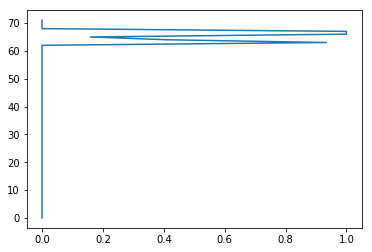

In [69]:
import matplotlib.pyplot as plt

plt.plot(test[2,:,-3], np.arange(72))
plt.show()